In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde

from pathlib import Path

from parameters import N, beta, sigma, S0, I0, R0

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


This model leads to the following equations

$$
\begin{aligned}
\frac{dS}{dt} &= - \frac{\beta S}{N} I  \\
\frac{dI}{dt} &= \frac{\beta S}{N} I - \sigma I\\
\frac{dR}{dt} &= \sigma I
\end{aligned}
$$

In [2]:
data_filepath = Path().resolve().parent / "data" / "sir_noise1.csv"
data_observed = pd.read_csv(data_filepath)
data_observed.head()

,t,S,I,R
0,0.0,1005.417789,0.586835,1.540087
1,1.0,1003.441002,1.228361,2.904291
2,2.0,998.281447,1.865483,0.005710
3,3.0,997.057816,4.706242,4.693703
4,4.0,999.252545,10.108896,-4.981449


In [3]:
parameters_real = {"beta": beta, "sigma": sigma}

t_observed = data_observed[["t"]].to_numpy()
S_observed = data_observed[["S"]].to_numpy()
I_observed = data_observed[["I"]].to_numpy()
R_observed = data_observed[["R"]].to_numpy()

### Varibles

In [4]:
_beta = dde.Variable(0.0)
_sigma = dde.Variable(0.0)

### ODE Residuals

In [5]:
def ode(t, y):

    S = y[:, 0:1]
    I = y[:, 1:2]
    R = y[:, 2:3]

    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)

    return [
        dS_dt - ( - _beta * S / N * I ),
        dI_dt - ( _beta * S / N * I - _sigma * I  ),
        dR_dt - ( _sigma * I ),
        N - ( S + I + R)
    ]

### Initial Conditions

In [6]:
# Geometry
geom = dde.geometry.TimeDomain(t_observed[0, 0], t_observed[-1, 0])

# Boundaries
def boundary(_, on_initial):
    return on_initial

### Observed Data

In [7]:
observed_S = dde.icbc.PointSetBC(t_observed, S_observed, component=0)
observed_I = dde.icbc.PointSetBC(t_observed, I_observed, component=1)
observed_R = dde.icbc.PointSetBC(t_observed, R_observed, component=2)

### Data Model

In [8]:
data = dde.data.PDE(
    geom,
    ode,
    [
        observed_S,
        observed_I,
        observed_R
    ],
    num_domain=0,
    num_boundary=2,
    anchors=t_observed,
)

### Neural Network

In [9]:
neurons = 32
layers = 3
activation = "relu"
net = dde.nn.FNN([1] + [neurons] * layers + [3], activation, "Glorot uniform")

### Training

In [10]:
variable_filename = "sir_variables.dat"
variable = dde.callbacks.VariableValue(
    [_beta, _sigma],
    period=100,
    filename=variable_filename
)

Compiling model...
'compile' took 0.333846 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [4.52e-05, 6.12e-03, 7.60e-03, 1.00e+06, 2.35e+05, 8.21e+04, 3.86e+05]    [4.52e-05, 6.12e-03, 7.60e-03, 1.00e+06, 2.35e+05, 8.21e+04, 3.86e+05]    []  
5000      [3.15e+01, 1.91e+01, 7.79e+00, 8.78e+00, 2.35e+01, 1.56e+01, 2.37e+01]    [3.15e+01, 1.91e+01, 7.79e+00, 8.78e+00, 2.35e+01, 1.56e+01, 2.37e+01]    []  
10000     [1.39e+01, 1.16e+01, 5.13e+00, 2.63e+00, 1.75e+01, 6.57e+00, 1.56e+01]    [1.39e+01, 1.16e+01, 5.13e+00, 2.63e+00, 1.75e+01, 6.57e+00, 1.56e+01]    []  
15000     [1.07e+01, 1.05e+01, 4.75e+00, 1.84e+00, 1.70e+01, 5.52e+00, 1.24e+01]    [1.07e+01, 1.05e+01, 4.75e+00, 1.84e+00, 1.70e+01, 5.52e+00, 1.24e+01]    []  
20000     [9.31e+00, 9.40e+00, 4.16e+00, 1.34e+00, 1.70e+01, 5.22e+00, 1.16e+01]    [9.31e+00, 9.40e+00, 4.16e+00

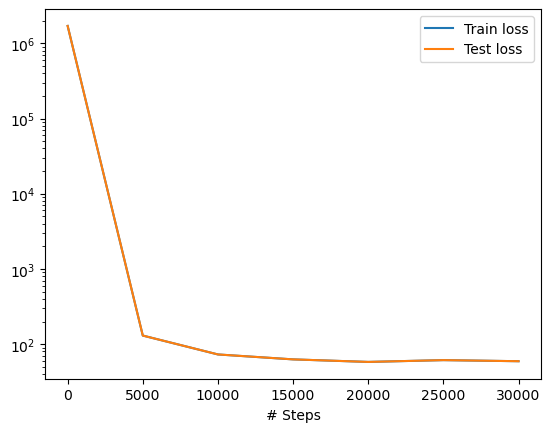

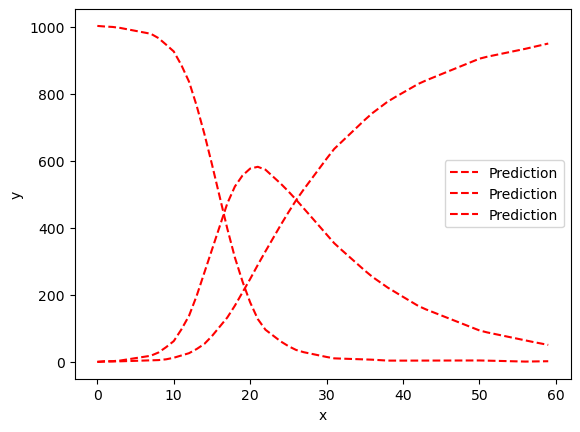

In [11]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=[_beta, _sigma]
)
losshistory, train_state = model.train(
    iterations=30000,
    display_every=5000,
    callbacks=[variable]
)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

We can plot training and predicted data in the sample picture. You will notice it is almost perfect, which makes sense, since we are predicting data we already know.

In [12]:
model_name = "SIR"
populations_names = list(model_name)
data_observed_melted = data_observed.melt(id_vars="t", var_name="status", value_name="population")

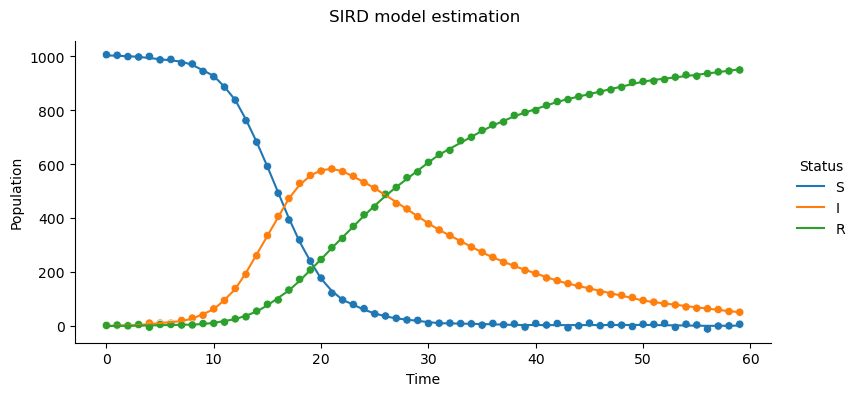

In [13]:
y_pred = model.predict(t_observed)
data_pred = (
    pd.DataFrame(y_pred, columns=list("SIR"), index=t_observed.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
    height=4
)

sns.scatterplot(
    data=data_observed_melted,
    x="t",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")

# plt.savefig("sird_prediction.png", dpi=300)
plt.show()

## Learning History

In [14]:
lines = open(f"{model_name}_variables.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {
    name: raw_parameters_pred_history[:, i]
    for i, (name, nominal) in enumerate(parameters_real.items())
}

/tmp/ipykernel_24239/413052011.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


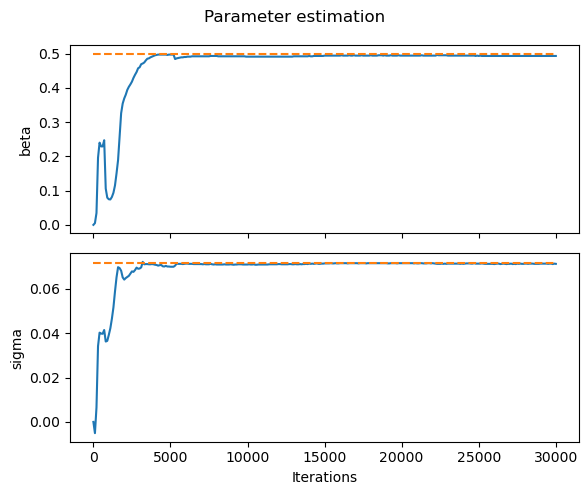

In [15]:
n_callbacks, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True, figsize=(6, 5), layout="constrained")
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()
# fig.savefig("sird_parameter_estimation.png", dpi=300)

In [16]:
parameters_pred = {
    name: var for name, var in zip(parameters_real.keys(), variable.value)
}
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
error_df

,Real,Predicted,Relative Error
beta,0.500000,0.493485,0.013031
sigma,0.071429,0.071167,0.003663


In [17]:
# print(
#     error_df.style
#     .format(
#         {
#             "Real": "{:.4f}",
#             "Predicted": "{:.4f}",
#             "Relative Error": "{:.4f}",
#         }
#     ).to_latex(
#         label="tab:sird_errors",
#         caption="Parameter predictions and relative errors for SIRD model.",
#     )
# )